In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re

from langdetect import detect
from scipy.stats import f_oneway
from collections import Counter

nltk.download("stopwords", quiet=True)

from nltk.stem.snowball import SpanishStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

In [91]:
df_data = pd.read_excel(r"df_retrain\datos_retrain.xlsx")
df_data.head()
df = df_data.dropna(subset=["textos", "labels"])
df = df.drop_duplicates(subset=["textos", "labels"])

wpt = nltk.WordPunctTokenizer()
stop_words = set(nltk.corpus.stopwords.words("spanish"))

spanish_stemmer = SpanishStemmer()


def tokenize_text(text, stem=True):
    # Elimina caracteres especiales y espacios en blanco
    doc = re.sub(r"[^A-Za-zÁÉÍÓÚáéíóúÜüÑñ\s]", "", text, flags=re.U)  # Unicode aware
    doc = doc.lower()
    doc = doc.strip()
    # Tokenizar documento
    tokens = wpt.tokenize(doc)
    # Filtrar palabras
    filtered_tokens = [
        spanish_stemmer.stem(token) if stem else token
        for token in tokens
        if token not in stop_words
    ]
    # Recrear documento de texto
    doc = " ".join(filtered_tokens)
    return doc, filtered_tokens


normalized_df = df.copy()
normalized_df[["tokenized_text", "tokens"]] = normalized_df["textos"].apply(
    lambda x: pd.Series(tokenize_text(x, stem=False))
)


normalized_df.head()


,textos,labels,tokenized_text,tokens
0,"Actualmente, la Asamblea Legislativa está discutiendo una propuesta muy bienvenida para hacer obligatoria la acreditación de todos los programas de enseñanza en universidades privadas, como parte de un esfuerzo por elevar la calidad de la formación inicial de los docentes y adecuar los cursos a los requisitos de una nueva escuela. plan de estudios. Las evaluaciones de los docentes muestran que el 40% de los docentes de inglés y el 29% de los docentes de matemáticas no dominan el contenido del plan de estudios que se espera que enseñen. Si bien los cursos nacionales de capacitación han mejorado, los docentes reciben poco apoyo regular y retroalimentación sobre su práctica docente.",4,actualmente asamblea legislativa discutiendo propuesta bienvenida hacer obligatoria acreditación programas enseñanza universidades privadas parte esfuerzo elevar calidad formación inicial docentes adecuar cursos requisitos nueva escuela plan estudios evaluaciones docentes muestran docentes inglés docentes matemáticas dominan contenido plan estudios espera enseñen si bien cursos nacionales capacitación mejorado docentes reciben apoyo regular retroalimentación práctica docente,"[actualmente, asamblea, legislativa, discutiendo, propuesta, bienvenida, hacer, obligatoria, acreditación, programas, enseñanza, universidades, privadas, parte, esfuerzo, elevar, calidad, formación, inicial, docentes, adecuar, cursos, requisitos, nueva, escuela, plan, estudios, evaluaciones, docentes, muestran, docentes, inglés, docentes, matemáticas, dominan, contenido, plan, estudios, espera, enseñen, si, bien, cursos, nacionales, capacitación, mejorado, docentes, reciben, apoyo, regular, retroalimentación, práctica, docente]"
1,"Específicamente, el costo de un beneficio de $2,50 por día para todas las personas mayores de 60 años o más oscila entre el 0,5% y el 2,7% del PIB, siendo el costo mayor para los países más pobres, donde $2,50 representa una mayor proporción del ingreso promedio. El riesgo de pobreza entre las personas mayores ha disminuido, mientras que las tasas de pobreza entre los adultos jóvenes y las familias con niños han aumentado. Sin embargo, debido a que las tasas iniciales de pobreza en la vejez eran muy altas, las personas de 75 años o más siguen siendo el grupo con más probabilidades de ser pobres. Las personas de 66 a 75 años, en cambio, ahora no tienen más probabilidades de ser pobres que la población en su conjunto.",1,específicamente costo beneficio día todas personas mayores años oscila pib siendo costo mayor países pobres representa mayor proporción ingreso promedio riesgo pobreza personas mayores disminuido mientras tasas pobreza adultos jóvenes familias niños aumentado embargo debido tasas iniciales pobreza vejez altas personas años siguen siendo grupo probabilidades ser pobres personas años cambio ahora probabilidades ser pobres población conjunto,"[específicamente, costo, beneficio, día, todas, personas, mayores, años, oscila, pib, siendo, costo, mayor, países, pobres, representa, mayor, proporción, ingreso, promedio, riesgo, pobreza, personas, mayores, disminuido, mientras, tasas, pobreza, adultos, jóvenes, familias, niños, aumentado, embargo, debido, tasas, iniciales, pobreza, vejez, altas, personas, años, siguen, siendo, grupo, probabilidades, ser, pobres, personas, años, cambio, ahora, probabilidades, ser, pobres, población, conjunto]"
2,"Sin embargo, la calidad general del entorno de EAPI tuvo un efecto sobre los ingresos de los adultos. En muchos países, las proporciones entre el personal y los niños se han regulado con proporciones más altas entre el personal y los niños para los más pequeños y proporciones más bajas para los niños mayores (NICHD, 2002). Sin embargo, falta investigación sobre exactamente qué proporción es más favorable para mejorar la satisfacción laboral de los docentes, la calidad de la EAPI y los resultados de los niños.",4,embargo calidad general entorno eapi efecto ingresos 

In [92]:
X = normalized_df["tokenized_text"]
y = normalized_df["labels"]
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)


In [93]:
def logistic_n_gram(n_grama_param, X_train, X_test, y_train, y_test):
    vectorizer_ngram = CountVectorizer(ngram_range=n_grama_param)
    X_train_ngram = vectorizer_ngram.fit_transform(X_train.fillna(""))
    X_test_ngram = vectorizer_ngram.transform(X_test.fillna(""))

    # Modelo
    log_n = LogisticRegression(max_iter=1000, random_state=42)
    log_n.fit(X_train_ngram, y_train)
    y_pred = log_n.predict(X_test_ngram)

    # Métricas
    print(f"N-grama {n_grama_param}:")
    print("F1 score:", f1_score(y_test, y_pred, average="macro"))
    print("Precision:", precision_score(y_test, y_pred, average="macro"))
    print("Recall:", recall_score(y_test, y_pred, average="macro"))
    print(classification_report(y_test, y_pred))

logistic_n_gram((1, 1), X_train_text, X_test_text, y_train, y_test)

N-grama (1, 1):
F1 score: 0.9502802267508149
Precision: 0.9506405488056865
Recall: 0.950017814424594
              precision    recall  f1-score   support

           1       0.94      0.94      0.94       111
           3       0.93      0.95      0.94       118
           4       0.98      0.96      0.97       111

    accuracy                           0.95       340
   macro avg       0.95      0.95      0.95       340
weighted avg       0.95      0.95      0.95       340



In [94]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import FunctionTransformer


In [95]:
df = pd.read_excel(r"df_retrain\datos_retrain.xlsx")

In [96]:
pd.set_option('display.max_colwidth', None)

In [97]:
X = df["textos"]
y = df["labels"]
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [109]:
import cloudpickle
from sklearn.pipeline import Pipeline
import WordTokenizer
from WordTokenizer import WordTokenizerTransformer

X = df["textos"]
y = df["labels"]
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tokenizer = WordTokenizerTransformer()
#df_token = tokenizer.fit_transform(X_train_text)

pipeline = Pipeline([
    ('tokenize', tokenizer),
    ('vectorizer', CountVectorizer(ngram_range=(1,1))),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

pipeline.fit(X_train_text, y_train)

# Evaluar
y_pred = pipeline.predict(X_test_text)

cloudpickle.register_pickle_by_value(WordTokenizer)

with open('pipeline.cloudpkl', mode='wb') as file:
    cloudpickle.dump(pipeline, file)

precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")
report = classification_report(y_test, y_pred)


print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print(report)

Precision:  0.9586510772100292
Recall:  0.9586831223511186
F1 Score:  0.9586579041916613
              precision    recall  f1-score   support

           1       0.95      0.95      0.95       228
           3       0.95      0.95      0.95       219
           4       0.98      0.97      0.97       233

    accuracy                           0.96       680
   macro avg       0.96      0.96      0.96       680
weighted avg       0.96      0.96      0.96       680



## Metodos de reentrenamiento 
A continuación, se revisan diferentes métodos de reentrenamiento analizando sus ventajas y desventajas y decidiendo cuál implementar dentro del modelo final.
### Método 1: Reentrenamiento completo
Este método consiste en tomar las nuevas instancias y reentrenar todo el modelo al unir los sets de datos. Entre las ventajas de este método se incluye que permite un aprendizaje completo del modelo, lo que lo puede hacer más robusto frente a diferentes casos. Sin embargo, entre sus desventajas se reslata que requiere más tiempo y tiene un costo computacional más elevado, lo que dependiendo de la aplicación puede no ser deseado. 
A continuación, se utilizan unos datos adicionales para modelar las diferentes formas en las qu se realiza el reentrenamiento para comparar adecuadamente el desarrollo. 

In [99]:
df_nuevo = pd.read_csv(r"datos\datos_nuevos_retrain.csv")

In [100]:
df_og = pd.read_excel(r"df_retrain\datos_retrain.xlsx")
df_unified = pd.concat([df_nuevo, df_og])

with open("pipeline.cloudpkl", "rb") as f:
    model = cloudpickle.load(f)

X = df_unified['textos']
y = df_unified['labels']
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model.fit(X_train_text, y_train)
y_pred = model.predict(X_test_text)


precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")
report = classification_report(y_test, y_pred)


print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print(report)

Precision:  0.9566249437667046
Recall:  0.9577206923905037
F1 Score:  0.9569939068185854
              precision    recall  f1-score   support

           1       0.93      0.96      0.95       111
           3       0.97      0.94      0.95       128
           4       0.97      0.97      0.97       106

    accuracy                           0.96       345
   macro avg       0.96      0.96      0.96       345
weighted avg       0.96      0.96      0.96       345



### Método 2: Reentrenamiento incremental

Algunos tipos de modelos permiten un reentrenamiento parcial en donde se procesa sobre los datos nuevos nada más. Esto resulta útil para modelos que no tengan los recursos para soportar un entrenamiento completo, o requieran aplicaciones más rápidas en tiempo. Sin embargo, una de las desventajas de este método es que no todos los modelos lo soportan. En particular, `Logistic Regression` no soporta este tipo de reentrenamiento a diferencia de modelos como `SGDClassifier` y `PassiveAggressiveClassifier` lo cual lo hace incompatible para este caso. 

In [101]:
df_nuevo = pd.read_csv(r"datos\datos_nuevos_retrain.csv")
df_og = pd.read_excel(r"df_retrain\datos_retrain.xlsx")

tokenizer = WordTokenizerTransformer()

pipeline = Pipeline([
    ('tokenize', tokenizer),
    ('vectorizer', CountVectorizer(ngram_range=(1,1)))
])

X = pipeline.fit_transform(df_og["textos"])  
y = df_og["labels"]

model = SGDClassifier(loss='log_loss', max_iter=1000)


X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model.partial_fit(X_train_text, y_train, classes=np.unique(y_train))
y_pred = model.predict(X_test_text)

precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")
report = classification_report(y_test, y_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print(report)

X_new = pipeline.transform(df_nuevo["textos"])  
y_new = df_nuevo["labels"]

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.3, random_state=42)

model.partial_fit(X_new, y_new)

y_pred = model.predict(X_test_new)

precision = precision_score(y_test_new, y_pred, average="macro")
recall = recall_score(y_test_new, y_pred, average="macro")
f1 = f1_score(y_test_new, y_pred, average="macro")
report = classification_report(y_test_new, y_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print(report)



Precision:  0.9478026285754924
Recall:  0.9473530353211698
F1 Score:  0.9469354645566099
              precision    recall  f1-score   support

           1       0.97      0.92      0.94       228
           3       0.91      0.97      0.94       219
           4       0.97      0.95      0.96       233

    accuracy                           0.95       680
   macro avg       0.95      0.95      0.95       680
weighted avg       0.95      0.95      0.95       680

Precision:  1.0
Recall:  1.0
F1 Score:  1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         4

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



### Método 3: Ventanas de tiempo
En algunos contextos resulta útil e interesante utilizar un reentrenamiento con ventanas de tiempo. Esto significa que se van eliminando los datos más viejos y se mantienen los nuevos. Esto tiene sentido para problemas en los que el comportamiento de las distribuciones cambia y se presentan situaciones cambiantes con el tiempo que pueden no ser representadas correctamente a partir de los datos nuevos. 
En este problema en particular, siempre se desea clasificar los datos entre 3 ODS que no cambian de definición. Esto hace que el uso de ventanas de tiempo no sea necesariamente el más adecuado. Es así como una de las ventajas de este método es que permite adaptarse mejor a los nuevos datos y darles más relevancia, lo que ayuda cuando cambian los patrones a lo largo del tiempo. Sin embargo, una de las desventajas de este método es que si los patrones no cambian, se puede llegar a perder información útil para el desempeño del modelo. 
Para la implementación de este caso, se eliminarán datos viejos y se agregaran nuevos. Se eliminan los n datos nuevos que se agreguen por clase. 

In [102]:
df_nuevo = pd.read_csv(r"datos\datos_nuevos_retrain.csv")
df_og = pd.read_excel(r"df_retrain\datos_retrain.xlsx")

df_og_filtrado = df_og.copy()

for label, group in df_nuevo.groupby('labels'):
    n_nuevos = len(group)
    # Filtrar registros viejos de esa clase
    mask_clase = df_og_filtrado['labels'] == label
    indices_clase = df_og_filtrado[mask_clase].index

    # Eliminar los primeros n registros viejos de esa clase
    if len(indices_clase) >= n_nuevos:
        indices_a_eliminar = indices_clase[:n_nuevos]
        df_og_filtrado = df_og_filtrado.drop(indices_a_eliminar)
    
df_unified = pd.concat([df_nuevo, df_og_filtrado], ignore_index=True)

with open("pipeline.cloudpkl", "rb") as f:
    model = cloudpickle.load(f)

X = df_unified['textos']
y = df_unified['labels']

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

model.fit(X_train_text, y_train)
y_pred = model.predict(X_test_text)

precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")
report = classification_report(y_test, y_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print(report)


Precision:  0.9474548440065682
Recall:  0.9470061584640067
F1 Score:  0.9471459139318629
              precision    recall  f1-score   support

           1       0.95      0.94      0.94       113
           3       0.91      0.94      0.93       113
           4       0.98      0.96      0.97       114

    accuracy                           0.95       340
   macro avg       0.95      0.95      0.95       340
weighted avg       0.95      0.95      0.95       340



### Método 4: Reentrenamiento completo con ajuste de peso
Finalmente, se propone nuevamente el uso de reentrenamiento completo del modelo pero se usa un ajuste de pesos dentro del modelo. La ventaja de esto es que además de usar todos los datos, ajusta el peso de clases para responder frente a casos en los que se genere desbalanceo de clases. Esto puede ayudar a que si los datos nuevos generan un desbalance, el modelo compense este comportamiento automáticamente. Sin embargo, las desventajas de la implementación original se mantienen ya que al ser un reentrenamiento completo es computacionalmente complejo. 




#### Propuesta sin ajuste de peso

In [103]:
df_nuevo = pd.read_csv(r"datos\datos_ods4_100.csv")
df_og = pd.read_excel(r"df_retrain\datos_retrain.xlsx")
df_unified = pd.concat([df_nuevo, df_og])

with open("pipeline.cloudpkl", "rb") as f:
    model = cloudpickle.load(f)

X = df_unified['textos']
y = df_unified['labels']
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model.fit(X_train_text, y_train)
y_pred = model.predict(X_test_text)


precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")
report = classification_report(y_test, y_pred)


print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print(report)

Precision:  0.9549323759850076
Recall:  0.9542377747607022
F1 Score:  0.9541562598002379
              precision    recall  f1-score   support

           1       0.94      0.96      0.95       108
           3       0.97      0.92      0.94       118
           4       0.95      0.98      0.97       129

    accuracy                           0.95       355
   macro avg       0.95      0.95      0.95       355
weighted avg       0.96      0.95      0.95       355



#### Propuesta con ajuste de peso

In [104]:
df_nuevo = pd.read_csv(r"datos\datos_ods4_100.csv")
df_nuevo.head()

,textos,labels
0,La educación gratuita y de calidad es un derecho fundamental.,4
1,Los estudiantes deben aprender habilidades socioemocionales.,4
2,La calidad docente es el pilar de una buena educación.,4
3,"Las evaluaciones deben centrarse en el aprendizaje, no solo en calificaciones.",4
4,La cooperación internacional puede fortalecer los sistemas educativos.,4


In [105]:
df_og = pd.read_excel(r"df_retrain\datos_retrain.xlsx")
df_unified = pd.concat([df_nuevo, df_og])

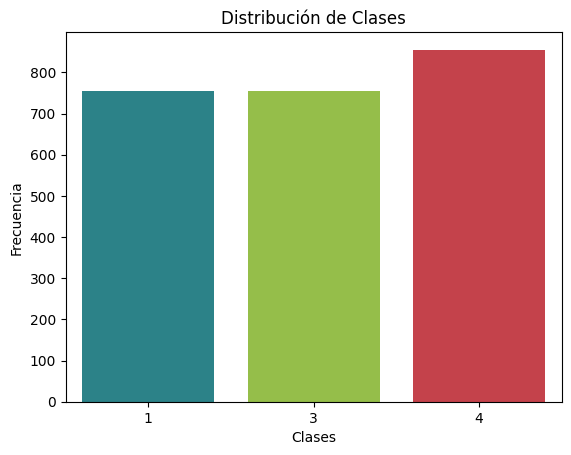

In [106]:
colors = {1: "#1D8F97", 3: "#9bd137", 4: "#DA2C38"}
value_counts = df_unified["labels"].value_counts()
x_values = value_counts.index
y_values = value_counts.values

sns.barplot(x=x_values, y=y_values, palette=colors, hue=x_values, legend=False)

plt.title("Distribución de Clases")
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.show()

In [107]:
with open("pipeline.cloudpkl", "rb") as f:
    model = cloudpickle.load(f)

X = df_unified['textos']
y = df_unified['labels']
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

classifier = model.named_steps["classifier"]
classifier.set_params(class_weight='balanced')

model.fit(X_train_text, y_train)
y_pred = model.predict(X_test_text)


precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")
report = classification_report(y_test, y_pred)


print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print(report)

Precision:  0.9578520164046479
Recall:  0.9570626335177642
F1 Score:  0.9571400587261519
              precision    recall  f1-score   support

           1       0.95      0.96      0.95       108
           3       0.97      0.92      0.95       118
           4       0.95      0.98      0.97       129

    accuracy                           0.96       355
   macro avg       0.96      0.96      0.96       355
weighted avg       0.96      0.96      0.96       355

